Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 1408, 1)          4         
 ormalization)                                                   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 4,358
Trainable params: 4,356
Non-trainable params: 2
_________________________________________________________________
Num GPUs Available:  0


D:\CSE299\Flutter\Anaconda\envs\EEG_Signal\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/2
25186/25186 [==============================] - 5071s 201ms/step - loss: 0.8416 - accuracy: 0.5184 - val_loss: 0.6949 - val_accuracy: 0.4927
Epoch 2/2
25186/25186 [==============================] - 5179s 206ms/step - loss: nan - accuracy: 0.5086 - val_loss: nan - val_accuracy: 0.5000


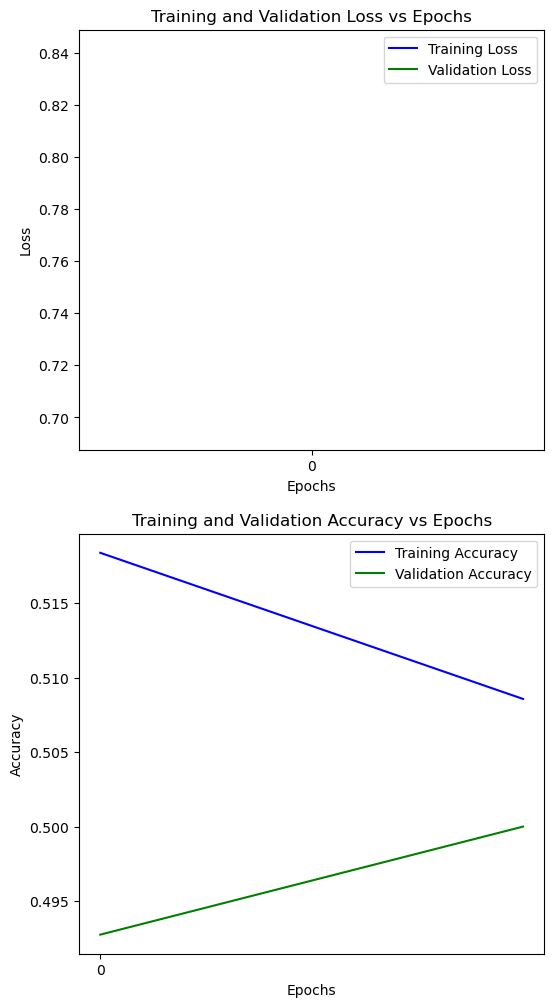

1617/1617 [==============================] - 68s 42ms/step


1.0

In [1]:
import numpy as np
import pandas as pd
from mat4py import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.utils import resample
import tensorflow
from tensorflow.keras.callbacks import ModelCheckpoint
import sklearn
import matplotlib.pyplot as plt
import pickle

list_string = ['ucddb002', 'ucddb003', 'ucddb005', 'ucddb006', 'ucddb007', 'ucddb009',
               'ucddb010', 'ucddb012', 'ucddb014', 'ucddb015', 'ucddb017',
               'ucddb019', 'ucddb020', 'ucddb021', 'ucddb022', 'ucddb023', 'ucddb024',
               'ucddb025', 'ucddb026', 'ucddb027', 'ucddb028']

valid_features = np.zeros((1, 1408))
test_features = np.zeros((1, 1408))
valid_labels = np.zeros((1, 1))
test_labels = np.zeros((1, 1))
for l in list_string:
        ecg_valid = loadmat('D:\\CSE499\\files2\\'+l+'_ecg_valid.mat')
        ecg_valid = np.array(ecg_valid['ecg_valid'])
        ecg_valid_labels=loadmat('D:\\CSE499\\files2\\'+l+'_valid_labels.mat')
        ecg_valid_labels = np.array(ecg_valid_labels['class_valid'])
        valid_features=np.append(valid_features,ecg_valid,axis=0)
        valid_labels=np.append(valid_labels,ecg_valid_labels)
       
        
        ecg_test = loadmat('D:\\CSE499\\files2\\'+l+'_ecg_test.mat')
        ecg_test = np.array(ecg_test['ecg_test'])
        ecg_test_labels=loadmat('D:\\CSE499\\files2\\'+l+'_test_labels.mat')
        ecg_test_labels = np.array(ecg_test_labels['class_test'])
        test_features=np.append(test_features,ecg_test,axis=0)
        test_labels=np.append(test_labels,ecg_test_labels)

ecg_valid = valid_features[1:, :]
valid_labels = valid_labels[1:]
valid_labels = valid_labels.flatten()

ecg_test = test_features[1:, :]
test_labels = test_labels[1:]
test_labels = test_labels.flatten()

train_features = np.zeros((1, 1408))
train_labels = np.zeros((1, 1))

for l in list_string:
        ecg_train = loadmat('D:\\CSE499\\files2\\'+l+'_ecg_train.mat')
        ecg_train = np.array(ecg_train['ecg_train'])
        ecg_train_labels=loadmat('D:\\CSE499\\files2\\'+l+'_train_labels.mat')
        ecg_train_labels = np.array(ecg_train_labels['class_train'])
        train_features=np.append(train_features,ecg_train,axis=0)
        train_labels=np.append(train_labels,ecg_train_labels)
        
ecg_train = train_features[1:, :]
train_labels = train_labels[1:]
train_labels = train_labels.flatten()

ecg_train_mean = np.mean(ecg_train)
ecg_train_std = np.std(ecg_train)

for i in range(ecg_train.shape[0]):
    ecg_train[i, :] = (ecg_train[i, :] - ecg_train_mean) / ecg_train_std

for i in range(ecg_valid.shape[0]):
    ecg_valid[i, :] = (ecg_valid[i, :] - ecg_train_mean) / ecg_train_std

for i in range(ecg_test.shape[0]):
    ecg_test[i, :] = (ecg_test[i, :] - ecg_train_mean) / ecg_train_std

ecg_train = np.expand_dims(ecg_train, axis=2)
ecg_valid = np.expand_dims(ecg_valid, axis=2)
ecg_test = np.expand_dims(ecg_test, axis=2)

y_train = train_labels
y_valid = valid_labels
y_test = test_labels

tensorflow.keras.backend.clear_session()

num_classes = 2

y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = tensorflow.keras.utils.to_categorical(y_train_num, num_classes)

y_valid_num = y_train_encoder.fit_transform(y_valid)
y_valid_wide = tensorflow.keras.utils.to_categorical(y_valid_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = tensorflow.keras.utils.to_categorical(y_test_num, num_classes)

# Define the RNN model
model_ecg = tensorflow.keras.Sequential()
model_ecg.add(tensorflow.keras.layers.BatchNormalization(input_shape=(1408, 1)))
model_ecg.add(tensorflow.keras.layers.SimpleRNN(64, activation='relu'))
model_ecg.add(tensorflow.keras.layers.Dense(2, kernel_regularizer=tensorflow.keras.regularizers.l2(0.01), bias_regularizer=tensorflow.keras.regularizers.l2(0.01), activation='softmax'))

model_ecg.summary()

batch_size = 32
epochs = 2

opt = tensorflow.keras.optimizers.Adam(lr=0.001)
model_ecg.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

best_weights_filepath_ecg = './best_weights_ecg_32layer.hdf5'

best_weights_filepath_ecg = './best_weights_ecg_32layer.hdf5'
mcp_ecg = ModelCheckpoint(best_weights_filepath_ecg, monitor="val_accuracy",
                          save_best_only=True, save_weights_only=False)

history = model_ecg.fit(ecg_train, y_train_wide,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(ecg_valid, y_valid_wide),
                        callbacks=[mcp_ecg])

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(6, 12))

plt.subplot(2, 1, 1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0, epochs)[0::100])
plt.title('Training and Validation Loss vs Epochs')
plt.legend()

plt.subplot(2, 1, 2)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(acc, 'blue', label='Training Accuracy')
plt.plot(val_acc, 'green', label='Validation Accuracy')
plt.xticks(range(0, epochs)[0::100])
plt.title('Training and Validation Accuracy vs Epochs')
plt.legend()
plt.savefig("plots_perf.svg")
plt.show()

model_ecg.load_weights('./best_weights_ecg_32layer.hdf5')
y_pred = model_ecg.predict(ecg_test)
predict_test = np.argmax(y_pred, axis=1)
predict_test = predict_test.reshape(predict_test.shape[0], 1)
cm = confusion_matrix(y_test_num, predict_test)
cm

(cm[1, 1] + cm[0, 0]) / (cm[1, 1] + cm[1, 0] + cm[0, 0] + cm[0, 1])

cm[1, 1] / (cm[1, 1] + cm[1, 0])

cm[0, 0] / (cm[0, 0] + cm[0, 1])


In [3]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

model_ecg.load_weights('./best_weights_ecg_32layer.hdf5')
y_pred = model_ecg.predict(ecg_test)
predict_test = np.argmax(y_pred, axis=1)
predict_test = predict_test.reshape(predict_test.shape[0], 1)

# Confusion Matrix
cm = confusion_matrix(y_test_num, predict_test)
print("Confusion Matrix:")
print(cm)

# Precision, Recall, F1 Score
precision = precision_score(y_test_num, predict_test)
recall = recall_score(y_test_num, predict_test)
f1 = f1_score(y_test_num, predict_test)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

accuracy = (cm[1, 1] + cm[0, 0]) / (cm[1, 1] + cm[1, 0] + cm[0, 0] + cm[0, 1])
print(f"Accuracy: {accuracy}")

1617/1617 [==============================] - 65s 40ms/step
Confusion Matrix:
[[50368     0]
 [ 1368     0]]
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy: 0.9735580640173187


D:\CSE299\Flutter\Anaconda\envs\EEG_Signal\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
